In [2]:
# =========================
# 1. KẾT NỐI GOOGLE DRIVE
# =========================
from google.colab import drive

# Kết nối với Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import zipfile
import os

# Đường dẫn tới file zip trong Google Drive
zip_path = '/content/drive/MyDrive/datasets/archive.zip'

# Thư mục giải nén ra
extract_path = '/content/FER_CNN_LSTM/dataset'

# Tạo thư mục nếu chưa có
os.makedirs(extract_path, exist_ok=True)

# Giải nén
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(" Giải nén hoàn tất! Kiểm tra thư mục:", extract_path)


 Giải nén hoàn tất! Kiểm tra thư mục: /content/FER_CNN_LSTM/dataset


In [8]:
import os
from collections import defaultdict

def count_images_by_class(folder_path):
    class_counts = defaultdict(int)
    total_images = 0

    for class_name in sorted(os.listdir(folder_path)):
        class_folder = os.path.join(folder_path, class_name)
        if os.path.isdir(class_folder):
            num_images = len([
                f for f in os.listdir(class_folder)
                if f.lower().endswith(('.jpg', '.png', '.jpeg'))
            ])
            class_counts[class_name] = num_images
            total_images += num_images

    return total_images, class_counts

# Đường dẫn đến thư mục chứa các thư mục cảm xúc
dataset_path = '/content/FER_CNN_LSTM/dataset'

# Đếm và in kết quả
total_images, emotion_counts = count_images_by_class(dataset_path)

print(f"\n Tổng số ảnh trong bộ CK+: {total_images}")
for emotion, count in emotion_counts.items():
    print(f" - {emotion}: {count} ảnh")



 Tổng số ảnh trong bộ CK+: 981
 - anger: 135 ảnh
 - contempt: 54 ảnh
 - disgust: 177 ảnh
 - fear: 75 ảnh
 - happy: 207 ảnh
 - sadness: 84 ảnh
 - surprise: 249 ảnh


In [9]:
# =========================
# 2. CÀI ĐẶT THƯ VIỆN
# =========================
!pip install tensorflow opencv-python matplotlib seaborn

In [10]:
# =========================
# 3. IMPORT THƯ VIỆN
# =========================
import os
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Dropout, Flatten, Dense,
                                     LSTM, TimeDistributed, BatchNormalization)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint

In [18]:
import os
import glob
import numpy as np
import cv2
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# =========================
# 4. CẤU HÌNH BAN ĐẦU
# =========================
IMG_SIZE = 48
NUM_CLASSES = 7
NUM_FRAMES = 3
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 1)
SEQ_SHAPE = (NUM_FRAMES, IMG_SIZE, IMG_SIZE, 1)
BATCH_SIZE = 64
EPOCHS = 50
LEARNING_RATE = 0.001

# =========================
# 5. LOAD DỮ LIỆU
# =========================
def load_ckplus_data(data_path, img_size=48):
    images = []
    labels = []
    label_names = sorted(os.listdir(data_path))

    for label in label_names:
        class_path = os.path.join(data_path, label)
        if not os.path.isdir(class_path):
            continue
        img_files = glob.glob(os.path.join(class_path, '*.jpg')) + glob.glob(os.path.join(class_path, '*.png'))
        for file in img_files:
            img = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (img_size, img_size))
            img = img.astype('float32') / 255.0
            images.append(img)
            labels.append(label)

    return np.array(images), np.array(labels)

# =========================
# GỌI HÀM LOAD DỮ LIỆU
# =========================
dataset_path = '/content/FER_CNN_LSTM/dataset'
X_all, y_all = load_ckplus_data(dataset_path, img_size=IMG_SIZE)

# =========================
# MÃ HÓA NHÃN (LabelEncoder + One-hot)
# =========================
label_encoder = LabelEncoder()
y_all_encoded = label_encoder.fit_transform(y_all)
NUM_CLASSES = len(label_encoder.classes_)  # Cập nhật lại nếu số nhãn khác 7

y_all_cat = to_categorical(y_all_encoded, num_classes=NUM_CLASSES)

# =========================
# THÊM KÊNH MÀU CHO ẢNH
# =========================
X_all = np.expand_dims(X_all, axis=-1)  # (samples, 48, 48, 1)

# =========================
# CHIA TRAIN/TEST 80:20
# =========================
X_train, X_test, y_train_cat, y_test_cat = train_test_split(
    X_all, y_all_cat, test_size=0.2, random_state=42, stratify=y_all_encoded
)

# =========================
# CHUYỂN THÀNH CHUỖI CHO LSTM
# =========================
def reshape_to_sequence(X, y, num_frames, img_size, num_classes):
    n = (X.shape[0] // num_frames) * num_frames
    X = X[:n]
    y = y[:n]
    X_seq = X.reshape((-1, num_frames, img_size, img_size, 1))
    y_seq = y.reshape((-1, num_frames, num_classes))
    y_seq_last = y_seq[:, -1, :]  # lấy nhãn của frame cuối
    return X_seq, y_seq_last

X_train_seq, y_train_seq = reshape_to_sequence(X_train, y_train_cat, NUM_FRAMES, IMG_SIZE, NUM_CLASSES)
X_test_seq,  y_test_seq  = reshape_to_sequence(X_test, y_test_cat, NUM_FRAMES, IMG_SIZE, NUM_CLASSES)


In [19]:
# =========================
# 6. XÂY DỰNG MÔ HÌNH CNN-LSTM
# =========================

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Dropout, Flatten, Dense,
                                     LSTM, TimeDistributed, BatchNormalization)
from tensorflow.keras.optimizers import Adam

# Khởi tạo mô hình tuần tự (Sequential)
model = Sequential()

# ----- BLOCK CNN 1 -----
# TimeDistributed áp dụng Conv2D cho từng frame trong chuỗi
model.add(TimeDistributed(Conv2D(32, (3, 3), activation='relu'),
                          input_shape=(NUM_FRAMES, IMG_SIZE, IMG_SIZE, 1)))
model.add(TimeDistributed(MaxPooling2D((2, 2))))     # Giảm kích thước không gian
model.add(TimeDistributed(BatchNormalization()))     # Chuẩn hóa dữ liệu từng frame
model.add(TimeDistributed(Dropout(0.3)))             # Dropout để giảm overfitting

# ----- BLOCK CNN 2 -----
model.add(TimeDistributed(Conv2D(64, (3, 3), activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(Flatten()))                # Chuyển tensor 2D thành vector đặc trưng

# ----- LSTM -----
# Xử lý chuỗi vector đặc trưng theo thời gian
model.add(LSTM(128))           # 128 đơn vị nhớ
model.add(Dropout(0.5))        # Dropout tiếp theo để tránh overfitting

# ----- FULLY CONNECTED (Output) -----
model.add(Dense(NUM_CLASSES, activation='softmax'))  # Softmax để phân loại cảm xúc

# ----- BIÊN DỊCH MÔ HÌNH -----
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE),   # Adam với learning rate đã định nghĩa
              loss='categorical_crossentropy',               # Dùng cho phân loại nhiều lớp
              metrics=['accuracy'])                          # Theo dõi độ chính xác trong training

# In cấu trúc mô hình
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_8              │ (None, 3, 46, 46, 32)  │           320 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_9              │ (None, 3, 23, 23, 32)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_10             │ (None, 3, 23, 23, 32)  │           128 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_11             │ (None, 3, 23, 23, 32)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_12             │ (None, 3, 21, 21, 64)  │        18,496 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_13             │ (None, 3, 10, 10, 64)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_14             │ (None, 3, 10, 10, 64)  │           256 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_15             │ (None, 3, 6400)        │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │     3,342,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,362,951 (12.83 MB)

 Trainable params: 3,362,759 (12.83 MB)

 Non-trainable params: 192 (768.00 B)

In [20]:
# =========================
# 7. CHUẨN HÓA DỮ LIỆU ĐẦU VÀO DẠNG CHUỖI
# =========================

def reshape_to_sequence(X, y, num_frames):
    """
    Cắt dữ liệu để đảm bảo chia hết cho num_frames,
    sau đó reshape thành dạng chuỗi cho mô hình CNN-LSTM.
    """
    n = (X.shape[0] // num_frames) * num_frames  # Cắt bớt ảnh dư
    X = X[:n]
    y = y[:n]

    # Reshape ảnh thành chuỗi: (số chuỗi, num_frames, 48, 48, 1)
    X_seq = X.reshape((-1, num_frames, IMG_SIZE, IMG_SIZE, 1))

    # Reshape nhãn và lấy nhãn cuối mỗi chuỗi làm đại diện
    y_seq = y.reshape((-1, num_frames, NUM_CLASSES))
    y_seq_last = y_seq[:, -1, :]  # lấy nhãn frame cuối làm nhãn đại diện

    return X_seq, y_seq_last

# Gọi hàm chuẩn hóa chuỗi
X_train_seq, y_train_seq = reshape_to_sequence(X_train, y_train_cat, NUM_FRAMES)
X_test_seq,  y_test_seq  = reshape_to_sequence(X_test, y_test_cat, NUM_FRAMES)

# In kiểm tra shape kết quả
print("X_train_seq shape:", X_train_seq.shape)
print("y_train_seq shape:", y_train_seq.shape)


X_train_seq shape: (261, 3, 48, 48, 1)
y_train_seq shape: (261, 7)


In [21]:
# =========================
# 8. HUẤN LUYỆN VỚI CALLBACK LƯU MÔ HÌNH MỖI 5 EPOCH
# =========================

from tensorflow.keras.callbacks import ModelCheckpoint

# Đường dẫn lưu mô hình (Google Drive)
checkpoint_dir = '/content/drive/MyDrive/FER_CNN_LSTM/checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

# Callback: Lưu mô hình mỗi 5 epoch
checkpoint_callback = ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir, 'model_epoch_{epoch:02d}.h5'),  # Tên file theo epoch
    save_weights_only=False,   # Lưu cả mô hình, không chỉ weights
    save_freq='epoch',         # Lưu theo mỗi epoch, ta kiểm tra bên trong để chỉ giữ lại mỗi 5 epoch nếu muốn
    verbose=1
)

# Callback: Lưu lịch sử huấn luyện (có thể thêm EarlyStopping hoặc ReduceLROnPlateau nếu cần)

# Huấn luyện mô hình
history = model.fit(
    X_train_seq, y_train_seq,                               # Dữ liệu huấn luyện
    validation_data=(X_test_seq, y_test_seq),               # Dữ liệu kiểm thử
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[checkpoint_callback],                        # Danh sách callback
    verbose=1
)


Epoch 1/50
3/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.1658 - loss: 2.0221
Epoch 1: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_01.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 603ms/step - accuracy: 0.1960 - loss: 2.0170 - val_accuracy: 0.2154 - val_loss: 1.8979
Epoch 2/50
3/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.3819 - loss: 1.6458
Epoch 2: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_02.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 414ms/step - accuracy: 0.4043 - loss: 1.6205 - val_accuracy: 0.2000 - val_loss: 1.9434
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5603 - loss: 1.3442
Epoch 3: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_03.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 428ms/step - accuracy: 0.5589 - loss: 1.3463 - val_accuracy: 0.1077 - val_loss: 2.1663
Epoch 4/50
3/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.6354 - loss: 1.1593
Epoch 4: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_04.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 458ms/step - accuracy: 0.6416 - loss: 1.1637 - val_accuracy: 0.1077 - val_loss: 2.3953
Epoch 5/50
3/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.6910 - loss: 1.0660 
Epoch 5: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_05.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 472ms/step - accuracy: 0.6906 - loss: 1.0507 - val_accuracy: 0.1077 - val_loss: 2.5792
Epoch 6/50
3/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.6858 - loss: 0.8948 
Epoch 6: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_06.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.6867 - loss: 0.9149 - val_accuracy: 0.1077 - val_loss: 2.7878
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.7739 - loss: 0.8100
Epoch 7: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_07.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 489ms/step - accuracy: 0.7694 - loss: 0.8153 - val_accuracy: 0.1077 - val_loss: 2.7639
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.7769 - loss: 0.7611
Epoch 8: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_08.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 846ms/step - accuracy: 0.7758 - loss: 0.7611 - val_accuracy: 0.1077 - val_loss: 2.8393
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.7896 - loss: 0.7211
Epoch 9: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_09.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 530ms/step - accuracy: 0.7908 - loss: 0.7226 - val_accuracy: 0.1077 - val_loss: 3.0603
Epoch 10/50
4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.8057 - loss: 0.6594
Epoch 10: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_10.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 661ms/step - accuracy: 0.8168 - loss: 0.6414 - val_accuracy: 0.1077 - val_loss: 3.1175
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.8512 - loss: 0.5819
Epoch 11: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_11.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - accuracy: 0.8479 - loss: 0.5850 - val_accuracy: 0.1077 - val_loss: 3.0535
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.8922 - loss: 0.4410
Epoch 12: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_12.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.8884 - loss: 0.4485 - val_accuracy: 0.1077 - val_loss: 3.0781
Epoch 13/50
3/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8924 - loss: 0.4729
Epoch 13: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_13.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.8922 - loss: 0.4677 - val_accuracy: 0.1077 - val_loss: 3.1248
Epoch 14/50
3/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9253 - loss: 0.3806
Epoch 14: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_14.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 670ms/step - accuracy: 0.9183 - loss: 0.3855 - val_accuracy: 0.1077 - val_loss: 3.1390
Epoch 15/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9086 - loss: 0.3635
Epoch 15: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_15.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 0.9105 - loss: 0.3608 - val_accuracy: 0.1077 - val_loss: 3.0390
Epoch 16/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9461 - loss: 0.2995
Epoch 16: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_16.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - accuracy: 0.9455 - loss: 0.3015 - val_accuracy: 0.1077 - val_loss: 3.1673
Epoch 17/50
3/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9523 - loss: 0.2716
Epoch 17: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_17.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.9530 - loss: 0.2589 - val_accuracy: 0.1077 - val_loss: 3.1056
Epoch 18/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9585 - loss: 0.2667
Epoch 18: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_18.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.9578 - loss: 0.2660 - val_accuracy: 0.1077 - val_loss: 3.2288
Epoch 19/50
3/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9696 - loss: 0.2148
Epoch 19: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_19.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 333ms/step - accuracy: 0.9694 - loss: 0.2065 - val_accuracy: 0.1077 - val_loss: 3.2639
Epoch 20/50
3/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9792 - loss: 0.1944
Epoch 20: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_20.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9806 - loss: 0.1918 - val_accuracy: 0.1077 - val_loss: 3.2288
Epoch 21/50
3/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 1.0000 - loss: 0.1465
Epoch 21: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_21.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.9968 - loss: 0.1539 - val_accuracy: 0.1077 - val_loss: 3.2037
Epoch 22/50
3/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9896 - loss: 0.1734 
Epoch 22: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_22.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - accuracy: 0.9813 - loss: 0.1847 - val_accuracy: 0.1077 - val_loss: 3.0913
Epoch 23/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9694 - loss: 0.1921
Epoch 23: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_23.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.9694 - loss: 0.1909 - val_accuracy: 0.1077 - val_loss: 2.6523
Epoch 24/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9771 - loss: 0.1866
Epoch 24: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_24.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 0.9784 - loss: 0.1870 - val_accuracy: 0.1077 - val_loss: 2.9277
Epoch 25/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9870 - loss: 0.1783
Epoch 25: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_25.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 0.9873 - loss: 0.1757 - val_accuracy: 0.1077 - val_loss: 3.0135
Epoch 26/50
3/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9679 - loss: 0.1448
Epoch 26: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_26.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 198ms/step - accuracy: 0.9743 - loss: 0.1384 - val_accuracy: 0.1077 - val_loss: 2.9458
Epoch 27/50
4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9902 - loss: 0.1134
Epoch 27: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_27.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - accuracy: 0.9884 - loss: 0.1152 - val_accuracy: 0.1077 - val_loss: 2.9636
Epoch 28/50
4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9977 - loss: 0.1214
Epoch 28: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_28.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - accuracy: 0.9972 - loss: 0.1213 - val_accuracy: 0.1077 - val_loss: 3.0668
Epoch 29/50
3/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9983 - loss: 0.0748 
Epoch 29: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_29.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.9972 - loss: 0.0851 - val_accuracy: 0.1077 - val_loss: 2.9652
Epoch 30/50
3/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9983 - loss: 0.0881
Epoch 30: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_30.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.9972 - loss: 0.0896 - val_accuracy: 0.1077 - val_loss: 2.8075
Epoch 31/50
3/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 1.0000 - loss: 0.0823
Epoch 31: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_31.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 1.0000 - loss: 0.0788 - val_accuracy: 0.1077 - val_loss: 2.7452
Epoch 32/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9985 - loss: 0.0706
Epoch 32: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_32.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step - accuracy: 0.9981 - loss: 0.0711 - val_accuracy: 0.1077 - val_loss: 2.6891
Epoch 33/50
3/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 1.0000 - loss: 0.0649
Epoch 33: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_33.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 1.0000 - loss: 0.0682 - val_accuracy: 0.1385 - val_loss: 2.6745
Epoch 34/50
3/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 1.0000 - loss: 0.0667
Epoch 34: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_34.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 1.0000 - loss: 0.0707 - val_accuracy: 0.1385 - val_loss: 2.5870
Epoch 35/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9974 - loss: 0.0615
Epoch 35: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_35.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 0.9972 - loss: 0.0608 - val_accuracy: 0.1692 - val_loss: 2.3712
Epoch 36/50
3/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 1.0000 - loss: 0.0574
Epoch 36: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_36.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 1.0000 - loss: 0.0580 - val_accuracy: 0.1846 - val_loss: 2.1546
Epoch 37/50
3/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 1.0000 - loss: 0.0496
Epoch 37: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_37.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 1.0000 - loss: 0.0499 - val_accuracy: 0.2462 - val_loss: 1.9345
Epoch 38/50
4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 1.0000 - loss: 0.0521
Epoch 38: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_38.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 1.0000 - loss: 0.0519 - val_accuracy: 0.3077 - val_loss: 1.7003
Epoch 39/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 1.0000 - loss: 0.0484
Epoch 39: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_39.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 1.0000 - loss: 0.0489 - val_accuracy: 0.4000 - val_loss: 1.4855
Epoch 40/50
3/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 1.0000 - loss: 0.0587
Epoch 40: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_40.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 1.0000 - loss: 0.0553 - val_accuracy: 0.4308 - val_loss: 1.3942
Epoch 41/50
3/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 1.0000 - loss: 0.0418 
Epoch 41: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_41.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - accuracy: 1.0000 - loss: 0.0435 - val_accuracy: 0.4769 - val_loss: 1.2700
Epoch 42/50
3/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 1.0000 - loss: 0.0337 
Epoch 42: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_42.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - accuracy: 1.0000 - loss: 0.0367 - val_accuracy: 0.5846 - val_loss: 1.1244
Epoch 43/50
3/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 1.0000 - loss: 0.0447
Epoch 43: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_43.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 1.0000 - loss: 0.0469 - val_accuracy: 0.6308 - val_loss: 1.0010
Epoch 44/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 1.0000 - loss: 0.0415
Epoch 44: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_44.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 155ms/step - accuracy: 1.0000 - loss: 0.0425 - val_accuracy: 0.6615 - val_loss: 0.8366
Epoch 45/50
4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 1.0000 - loss: 0.0399
Epoch 45: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_45.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 1.0000 - loss: 0.0394 - val_accuracy: 0.7231 - val_loss: 0.7024
Epoch 46/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 1.0000 - loss: 0.0358
Epoch 46: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_46.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 185ms/step - accuracy: 1.0000 - loss: 0.0361 - val_accuracy: 0.7692 - val_loss: 0.5826
Epoch 47/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 1.0000 - loss: 0.0295
Epoch 47: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_47.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 183ms/step - accuracy: 1.0000 - loss: 0.0300 - val_accuracy: 0.8462 - val_loss: 0.4805
Epoch 48/50
3/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 1.0000 - loss: 0.0336 
Epoch 48: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_48.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - accuracy: 1.0000 - loss: 0.0365 - val_accuracy: 0.8615 - val_loss: 0.3914
Epoch 49/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 1.0000 - loss: 0.0307
Epoch 49: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_49.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 1.0000 - loss: 0.0310 - val_accuracy: 0.8769 - val_loss: 0.3555
Epoch 50/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 1.0000 - loss: 0.0362
Epoch 50: saving model to /content/drive/MyDrive/FER_CNN_LSTM/checkpoints/model_epoch_50.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 1.0000 - loss: 0.0360 - val_accuracy: 0.8615 - val_loss: 0.3607


In [26]:
# =========================
# 9. ĐÁNH GIÁ MÔ HÌNH
# =========================

from sklearn.metrics import classification_report, confusion_matrix

# -------------------------
# 9.1 Dự đoán trên tập kiểm thử
# -------------------------
y_pred_probs = model.predict(X_test_seq)                                # Xác suất dự đoán
y_pred_classes = np.argmax(y_pred_probs, axis=1)                        # Lấy nhãn dự đoán (số)
y_true_classes = np.argmax(y_test_seq, axis=1)                          # Lấy nhãn thật (số)

# -------------------------
# 9.2 Báo cáo độ chính xác, Precision, Recall, F1-Score
# -------------------------
print("=== Classification Report ===")
print(classification_report(y_true_classes, y_pred_classes, target_names=label_encoder.classes_))


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
=== Classification Report ===
              precision    recall  f1-score   support

       anger       1.00      0.38      0.55         8
    contempt       0.50      1.00      0.67         7
     disgust       0.88      1.00      0.93        14
        fear       1.00      0.57      0.73         7
       happy       1.00      1.00      1.00        12
     sadness       1.00      1.00      1.00         5
    surprise       1.00      0.92      0.96        12

    accuracy                           0.86        65
   macro avg       0.91      0.84      0.83        65
weighted avg       0.92      0.86      0.86        65



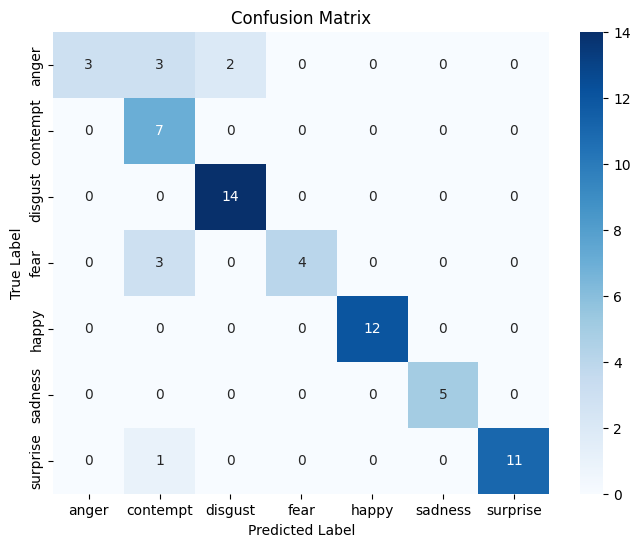

In [27]:
# -------------------------
# 9.3 Ma trận nhầm lẫn
# -------------------------
cm = confusion_matrix(y_true_classes, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


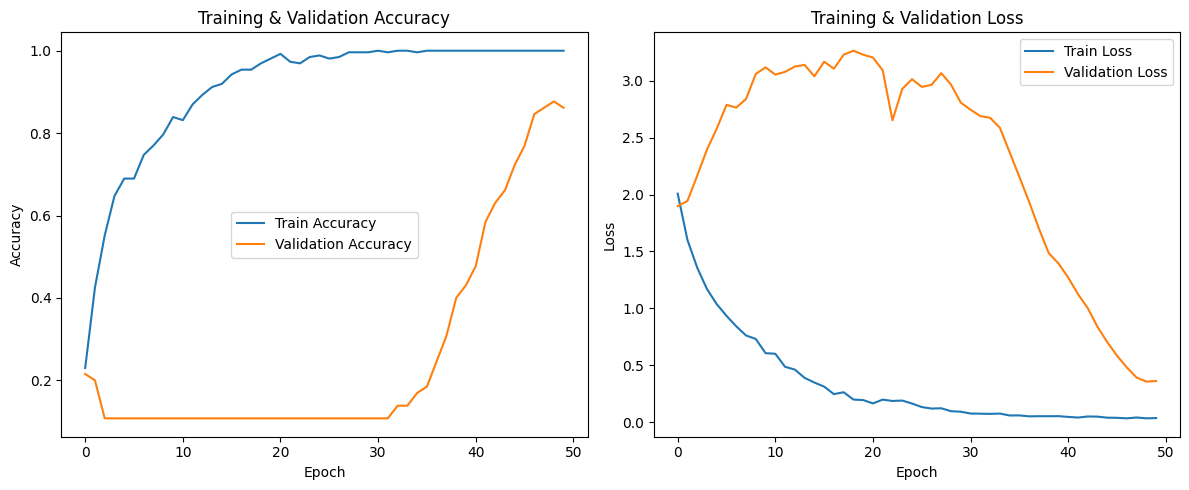

In [25]:
# -------------------------
# 9.4 Learning Curve (Độ chính xác & Độ mất mát)
# -------------------------
plt.figure(figsize=(12, 5))

# Độ chính xác
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Độ mất mát
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# =========================
# 10. LƯU MÔ HÌNH CUỐI CÙNG
# =========================
final_model_path = '/content/drive/MyDrive/FER_CNN_LSTM/model_final_cnn_lstm.h5'
model.save(final_model_path)
print(f" Mô hình đã được lưu tại: {final_model_path}")
